In [1]:

import os
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import deeplake
from time import time
from PIL import Image


from pathlib import Path
# set figure size
plt.rcParams['figure.figsize'] = [14, 14]
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Requirements taken from https://www.tensorflow.org/install/pip#linux
python_version = sys.version
pip_version = pip.__version__
nvidia_smi_version = os.popen('nvidia-smi --query-gpu=driver_version --format=csv,noheader').read().strip()
cuda_version = os.popen('nvcc --version').read().split('\n')[3].split(',')[1].strip()
tensorflow_version = tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
gpu_model = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()

req_xray_data = pd.DataFrame({
    'Package': ['Python', 'pip', 'nvidia-smi', 'cuda', 'tensorflow', 'GPUs'],
    'Required': ['3.7', '20.2', '450.51.06', '11.0', '2.3.0', '1'],
    'Installed': [python_version, pip_version, nvidia_smi_version, cuda_version, tensorflow_version, num_gpus]
})
               
print(f'All requiremetns met. Using TF with GPU: {gpu_model} ({num_gpus}x)')

pd.options.plotting.backend = "plotly"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from keras.models import Model, Sequential
from keras.layers import Lambda, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras
from sklearn.metrics import classification_report, accuracy_score

import sys

sys.path.append('/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/nih-chest')
sys.path.append(os.path.dirname(os.getcwd()))

from dataset import train_ds, val_ds, test_ds, y_test, y_val, ALL_LABELS
from reportUtils import generate_report, TEST

MODEL_NAME = 'Basic_CNN'

req_xray_data, TEST


2024-03-24 19:21:53.965844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 19:21:53.965887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 19:21:53.966930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 19:21:53.973155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 19:21:54.633404: W tensorflow/compiler/tf2

All requiremetns met. Using TF with GPU: NVIDIA GeForce GTX 1660 (1x)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


2024-03-24 19:21:55.894811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 19:21:56.215084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 19:21:56.215304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(      Package   Required                                          Installed
 0      Python        3.7  3.9.17 (main, Jul  5 2023, 20:41:20) \n[GCC 11...
 1         pip       20.2                                             23.2.1
 2  nvidia-smi  450.51.06                                          535.54.03
 3        cuda       11.0                                       release 12.2
 4  tensorflow      2.3.0                                             2.15.0
 5        GPUs          1                                                  1,
 100)

In [2]:
import sys

sys.path.append('/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/nih-chest')
sys.path.append(os.path.dirname(os.getcwd()))

from dataset import train_ds, val_ds, test_ds, y_test, y_val, ALL_LABELS
from reportUtils import generate_report, TEST

MODEL_NAME = 'Basic_CNN_V2'

req_xray_data, TEST

(      Package   Required                                          Installed
 0      Python        3.7  3.9.17 (main, Jul  5 2023, 20:41:20) \n[GCC 11...
 1         pip       20.2                                             23.2.1
 2  nvidia-smi  450.51.06                                          535.54.03
 3        cuda       11.0                                       release 12.2
 4  tensorflow      2.3.0                                             2.15.0
 5        GPUs          1                                                  1,
 100)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15


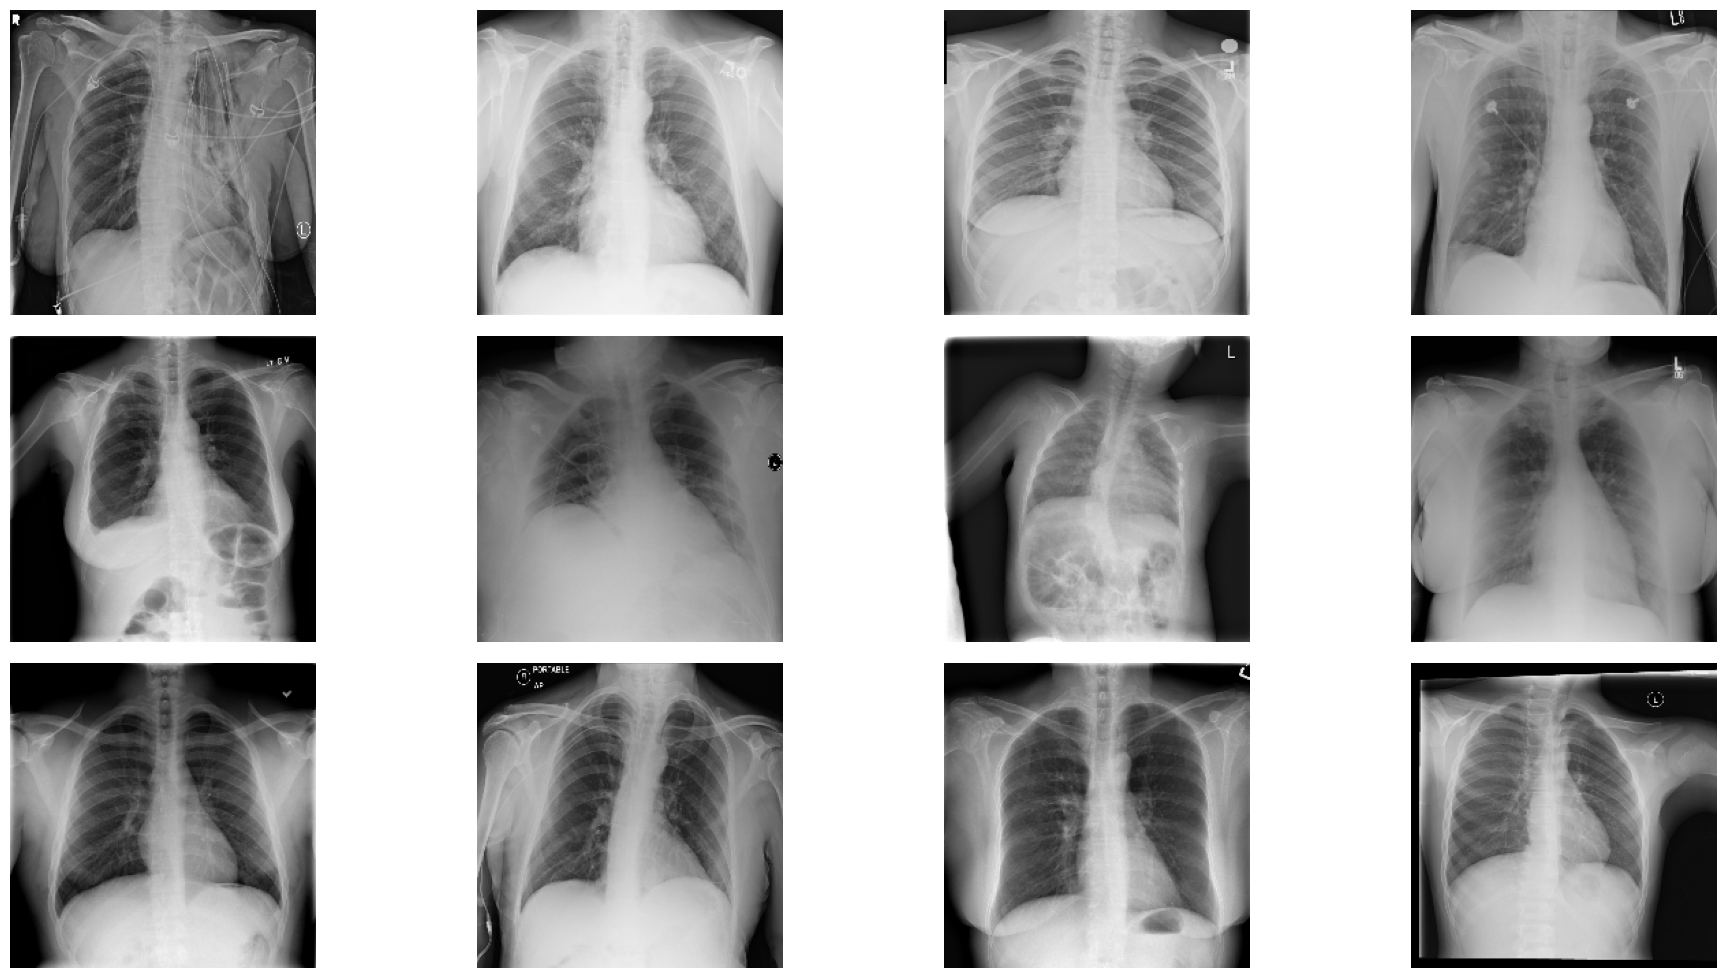

In [3]:
data, _ = train_ds.take(2)
images = data[0].numpy()
labels = data[1].numpy()
print(labels[0])
print(len(labels[0]))

fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
Basic_CNN = Sequential([
    # First convolutional layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flattening the results to feed into a dense layer
    Flatten(),

    # Output layer with sigmoid activation for multi-label classification
    Dense(15, activation='sigmoid')
])

plot_model(Basic_CNN, f"{MODEL_NAME}_model.png", show_shapes=True, show_layer_names=True)
weight_path=f"{MODEL_NAME}_weights.best.hdf5".format('Basic_CNN')

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4,
    patience = 5,
    mode = 'min', 
    restore_best_weights = True,
    verbose = 1)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-6)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]


Basic_CNN.compile(optimizer='adam', 
              loss=keras.losses.BinaryCrossentropy(label_smoothing=0.0), 
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc', multi_label=True)])

Basic_CNN.summary()

import gc
gc.collect()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 15)                1

664

In [5]:

# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    Basic_CNN.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.")

start = time()
Basic_CNN_history = Basic_CNN.fit(
                    train_ds,
                    epochs=2,
                    validation_data=val_ds,
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))
Basic_CNN.save(f"{MODEL_NAME}.keras")

Loading weights from: Basic_CNN_V2_weights.best.hdf5
Epoch 1/2


2024-03-24 19:21:58.552658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-24 19:22:05.110758: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff1cc00ebc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 19:22:05.110797: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-03-24 19:22:05.118604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711322525.215650 1143066 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2486/5769 [===========>..................] - ETA: 1:17 - loss: 0.1833 - accuracy: 0.9360 - precision: 0.6663 - recall: 0.4079 - auc: 0.6856

2024-03-24 19:23:04.098116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


5179/5769 [=========================>....] - ETA: 14s - loss: 0.1837 - accuracy: 0.9358 - precision: 0.6653 - recall: 0.4019 - auc: 0.6858

KeyboardInterrupt: 

: 

In [ ]:
generate_report(Basic_CNN, val_ds, y_val, MODEL_NAME, ALL_LABELS)

171/541 [========>.....................] - ETA: 21s

2024-03-24 19:12:18.553367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


541/541 [==============================] - 32s 59ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.647579,0.849306,0.734850,10080.0
Hernia,0.000000,0.000000,0.000000,32.0
Emphysema,0.000000,0.000000,0.000000,293.0
Nodule,0.000000,0.000000,0.000000,995.0
Pneumonia,0.000000,0.000000,0.000000,173.0
Consolidation,0.000000,0.000000,0.000000,600.0
Cardiomegaly,0.000000,0.000000,0.000000,349.0
Effusion,0.340541,0.036437,0.065831,1729.0
Mass,0.000000,0.000000,0.000000,845.0
Pleural_Thickening,0.000000,0.000000,0.000000,426.0


In [ ]:
generate_report(Basic_CNN, test_ds, y_test, MODEL_NAME, ALL_LABELS, "test")

800/800 [==============================] - 54s 68ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.482621,0.626610,0.545270,9861.0
Hernia,0.000000,0.000000,0.000000,86.0
Emphysema,0.000000,0.000000,0.000000,1093.0
Nodule,0.000000,0.000000,0.000000,1623.0
Pneumonia,0.000000,0.000000,0.000000,555.0
Consolidation,1.000000,0.000551,0.001101,1815.0
Cardiomegaly,0.000000,0.000000,0.000000,1069.0
Effusion,0.410029,0.059682,0.104198,4658.0
Mass,0.000000,0.000000,0.000000,1748.0
Pleural_Thickening,0.000000,0.000000,0.000000,1143.0


In [ ]:
generate_report(Basic_CNN, test_ds, y_test, MODEL_NAME, ALL_LABELS, "test")

NameError: name 'plot_metrics' is not defined